In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt


def reorientation_events_per_second(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None,
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])
    time = data['time']
    
    positions = np.stack((x_smooth, y_smooth, z_smooth), axis=1)

    # Calculate differences in positional vectors between consecutive points
    dir_vectors = np.diff(positions, axis=0)
    # Calculate magnitudes of vectors
    mags = np.linalg.norm(dir_vectors, axis=1)

    # Avoid division by zero
    non_zero_mags = mags > 0  
    unit_dir = np.zeros_like(dir_vectors)  
    unit_dir[non_zero_mags] = dir_vectors[non_zero_mags] / mags[non_zero_mags, np.newaxis]

    # Calculate dot products k steps ahead
    k = 5
    dot_products = [np.dot(unit_dir[i], unit_dir[i + k]) for i in range(len(unit_dir) - k) if i + k < len(unit_dir)]

    change_in_dir_threshold = 0.98
    consecutive_low_values = 3

    low_sequences = []
    current_sequence = []

    for dp in dot_products:
        if dp < change_in_dir_threshold:
            current_sequence.append(dp)
        else:
            if len(current_sequence) >= consecutive_low_values:
                low_sequences.append(current_sequence)
            current_sequence = []  # Reset for the next sequence

    if len(current_sequence) >= consecutive_low_values:
        low_sequences.append(current_sequence)

    # Calculate events per second
    events_per_sec = len(low_sequences) / (np.max(time) - np.min(time))
    return events_per_sec

In [2]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

def plot_reorientation_histogram(folder_path):
    all_files = glob.glob(os.path.join(folder_path, '*.txt'))
    
    # Initialize a list to store reorientation events per second
    reorientation_events = []

    # Iterate through all files in the directory
    for file_path in all_files:
        # Calculate reorientation events per second for each file
        reorientation_event = reorientation_events_per_second(file_path)
        
        # Append to list
        reorientation_events.append(reorientation_event)

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(reorientation_events, bins=100, color='skyblue')
    plt.xlabel('Reorientation Events per Second')
    plt.ylabel('Frequency')
    plt.savefig('Hist of reorientations.png')
    plt.title('Histogram of Reorientation Events per Second')
    plt.show()

# Example usage
folder_path = 'FINALDATA/WT_planktonic_final//'  # Replace with your folder path
plot_reorientation_histogram(folder_path)


KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import pandas as pd
import glob
import plotly.graph_objects as go


def plot_highest_reorientation_tracks(folder_path):
    all_files = glob.glob(os.path.join(folder_path, '*.txt'))
    reorientations = []
    reorientation_files = {}

    for file_path in all_files:
        reorientation = reorientation_events_per_second(file_path)
        reorientations.append(reorientation)
        reorientation_files[file_path] = reorientation # Keep track of file paths and their tortuosity values

    # Sort tortuosities and get the top 5
    highest_reorientation_data = sorted(reorientation_files.items(), key=lambda item: item[1], reverse=True)[:100]

    # Initialize the plot
    fig = go.Figure()

    # Plot the tracks for the files with the highest tortuosity values
    for file_path, reorientation in highest_reorientation_data:
        data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
        
        fig.add_trace(go.Scatter3d(
            x=data['x_smooth'],
            y=data['y_smooth'],
            z=data['z_smooth'],
            mode='lines+markers',
            name=os.path.basename(file_path),
            line=dict(width=2),
            marker=dict(size=3),
            text=f'Reorientation/s: {reorientation:.2f}'  # Display tortuosity in hover text
        ))

    # Update layout
    fig.update_layout(
        title='Tracks of Highest Reorientation/s Values',
        scene=dict(
            xaxis_title='X (µm)',
            yaxis_title='Y (µm)',
            zaxis_title='Z (µm)',
            aspectmode='cube'
        ),
        showlegend=True
    )

    # Show the plot
    fig.show()

# Example usage
folder_path = 'FINALDATA/WT_planktonic_final//'  # Replace with your folder path
plot_highest_reorientation_tracks(folder_path)


In [5]:
def plot_histogram(tortuosity_values):
    # Create histogram of tortuosity values
    plt.figure(figsize=(10, 6))
    plt.hist(tortuosity_values, bins=100, range = (0,100), color='blue', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Histogram of Tortuosity Values')
    plt.xlabel('Tortuosity')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

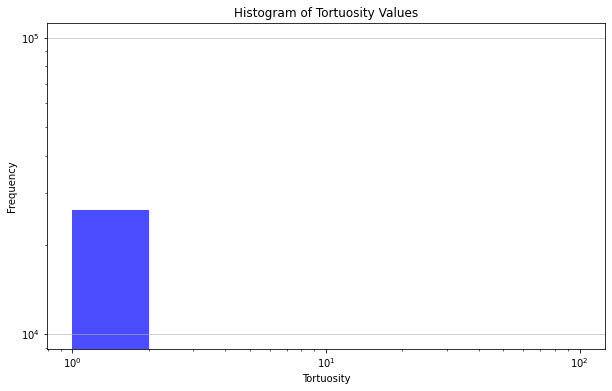

In [6]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

def calculate_path_length(file_path):
    # Read the data from the .txt file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None,
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Extract x_smooth, y_smooth, and z_smooth for path length calculation
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])

    # Calculate the path length as the sum of the distances between consecutive points
    path_length = np.sum(np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2 + np.diff(z_smooth)**2))
    
    return path_length

def calculate_straight_distance(file_path):
    # Read the data from the .txt file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None,
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Extract starting and ending coordinates
    start_point = data.iloc[0][['x_smooth', 'y_smooth', 'z_smooth']].to_numpy()
    end_point = data.iloc[-1][['x_smooth', 'y_smooth', 'z_smooth']].to_numpy()
    
    # Calculate the straight-line distance
    straight_distance = np.linalg.norm(end_point - start_point)
    
    return straight_distance

def calculate_tortuosity(file_path):
    path_length = calculate_path_length(file_path)
    straight_distance = calculate_straight_distance(file_path)
    
    # Avoid division by zero
    if straight_distance == 0:
        return np.inf  # Tortuosity is infinite if the straight distance is zero
    
    # Tortuosity calculation
    tortuosity = path_length / straight_distance
    return tortuosity

def tortuosity_for_all_files(folder_path):
    all_files = glob.glob(os.path.join(folder_path, '*.txt'))
    
    tortuosities = []
    
    # Iterate through all files in the directory
    for file_path in all_files:
        tortuosity = calculate_tortuosity(file_path)
        tortuosities.append(tortuosity)

    return tortuosities




folder_path = 'FINALDATA/Split_Data/WT/WTS/'  # Replace with your folder path
tortuosity_values = tortuosity_for_all_files(folder_path)


# Plot histogram of tortuosity values
plot_histogram(tortuosity_values)


In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import plotly.graph_objects as go

def calculate_tortuosity(file_path):
    # Read the data from the .txt file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Calculate the total path length
    x_smooth = data['x_smooth'].to_numpy()
    y_smooth = data['y_smooth'].to_numpy()
    z_smooth = data['z_smooth'].to_numpy()
    
    # Total path length (using Euclidean distance)
    path_length = np.sum(np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2 + np.diff(z_smooth)**2))
    
    # Calculate displacement
    start_point = np.array([x_smooth[0], y_smooth[0], z_smooth[0]])
    end_point = np.array([x_smooth[-1], y_smooth[-1], z_smooth[-1]])
    displacement = np.linalg.norm(end_point - start_point)  # Magnitude of the displacement vector

    # Tortuosity calculation
    tortuosity = path_length / displacement if displacement != 0 else np.nan  # Handle division by zero
    return tortuosity

def plot_highest_tortuosity_tracks(folder_path):
    all_files = glob.glob(os.path.join(folder_path, '*.txt'))
    tortuosities = []
    tortuosity_files = {}

    for file_path in all_files:
        tortuosity = calculate_tortuosity(file_path)
        tortuosities.append(tortuosity)
        tortuosity_files[file_path] = tortuosity  # Keep track of file paths and their tortuosity values

    # Sort tortuosities and get the top 5
    highest_tortuosity_data = sorted(tortuosity_files.items(), key=lambda item: item[1], reverse=True)[:100]

    # Initialize the plot
    fig = go.Figure()

    # Plot the tracks for the files with the highest tortuosity values
    for file_path, tortuosity in highest_tortuosity_data:
        data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
        
        fig.add_trace(go.Scatter3d(
            x=data['x_smooth'],
            y=data['y_smooth'],
            z=data['z_smooth'],
            mode='lines+markers',
            name=os.path.basename(file_path),
            line=dict(width=2),
            marker=dict(size=3),
            text=f'Tortuosity: {tortuosity:.2f}'  # Display tortuosity in hover text
        ))

    # Update layout
    fig.update_layout(
        title='Tracks of Highest Tortuosity Values',
        scene=dict(
            xaxis_title='X (µm)',
            yaxis_title='Y (µm)',
            zaxis_title='Z (µm)',
            aspectmode='cube'
        ),
        showlegend=False
    )

    # Show the plot
    fig.show()

# Example usage
folder_path = 'FINALDATA/Split_Data/Evolved+disk/EDS/'  # Replace with your folder path
plot_highest_tortuosity_tracks(folder_path)

In [9]:
import os
import numpy as np
import pandas as pd
import glob
import plotly.graph_objects as go

def calculate_tortuosity(file_path):
    # Read the data from the .txt file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Calculate the total path length
    x_smooth = data['x_smooth'].to_numpy()
    y_smooth = data['y_smooth'].to_numpy()
    z_smooth = data['z_smooth'].to_numpy()
    
    # Total path length (using Euclidean distance)
    path_length = np.sum(np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2 + np.diff(z_smooth)**2))
    
    # Calculate displacement
    start_point = np.array([x_smooth[0], y_smooth[0], z_smooth[0]])
    end_point = np.array([x_smooth[-1], y_smooth[-1], z_smooth[-1]])
    displacement = np.linalg.norm(end_point - start_point)  # Magnitude of the displacement vector

    # Tortuosity calculation
    tortuosity = path_length / displacement if displacement != 0 else np.nan  # Handle division by zero
    return tortuosity

def plot_lowest_tortuosity_tracks(folder_path):
    all_files = glob.glob(os.path.join(folder_path, '*.txt'))
    tortuosity_files = {}

    for file_path in all_files:
        tortuosity = calculate_tortuosity(file_path)
        tortuosity_files[file_path] = tortuosity  # Keep track of file paths and their tortuosity values

    # Sort tortuosities and get the 10 lowest
    lowest_tortuosity_data = sorted(tortuosity_files.items(), key=lambda item: item[1])[2900:3000]

    # Initialize the plot
    fig = go.Figure()

    # Plot the tracks for the files with the lowest tortuosity values
    for file_path, tortuosity in lowest_tortuosity_data:
        data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
        
        fig.add_trace(go.Scatter3d(
            x=data['x_smooth'],
            y=data['y_smooth'],
            z=data['z_smooth'],
            mode='lines+markers',
            name=os.path.basename(file_path),
            line=dict(width=2),
            marker=dict(size=3),
            text=f'Tortuosity: {tortuosity:.2f}'  # Display tortuosity in hover text
        ))

    # Update layout
    fig.update_layout(
        title='Tracks of Lowest Tortuosity Values',
        scene=dict(
            xaxis_title='X (µm)',
            yaxis_title='Y (µm)',
            zaxis_title='Z (µm)',
            aspectmode='cube'
        ),
        showlegend=True
    )

    # Show the plot
    fig.show()

# Example usage
folder_path = 'FINALDATA/Split_Data/Evolved+disk/EDS'  # Replace with your folder path
plot_lowest_tortuosity_tracks(folder_path)


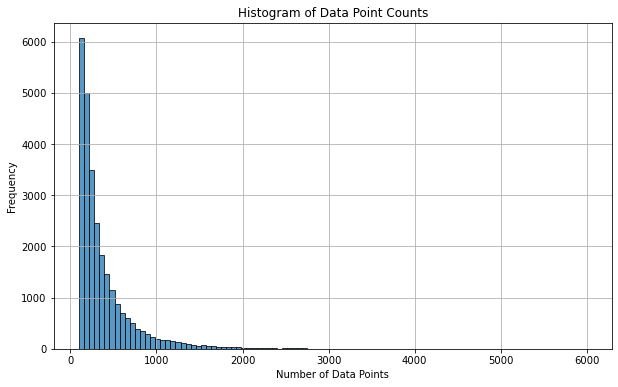

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def count_data_points_in_files(directory_path):
    """
    Counts the number of data points (rows) in each file in the given directory.

    Parameters:
    - directory_path: Path to the directory containing the files.

    Returns:
    - data_point_counts: List of data point counts for each file.
    """
    # Get all text files in the directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]

    data_point_counts = []

    for file_path in files:
        try:
            # Read the file to count rows
            data = pd.read_csv(file_path, delim_whitespace=True, header=None)
            num_rows = len(data)
            data_point_counts.append(num_rows)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    
    return data_point_counts

def plot_histogram(data_point_counts):
    """
    Plots a histogram of the data point counts.

    Parameters:
    - data_point_counts: List of data point counts for each file.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data_point_counts, bins=100, alpha=0.75, edgecolor='black')
    plt.xlabel('Number of Data Points')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data Point Counts')
    plt.grid(True)
    plt.show()

# Example Usage
directory_path = "FINALDATA/WT_planktonic_final/"  # Replace with your directory path
data_point_counts = count_data_points_in_files(directory_path)
plot_histogram(data_point_counts)


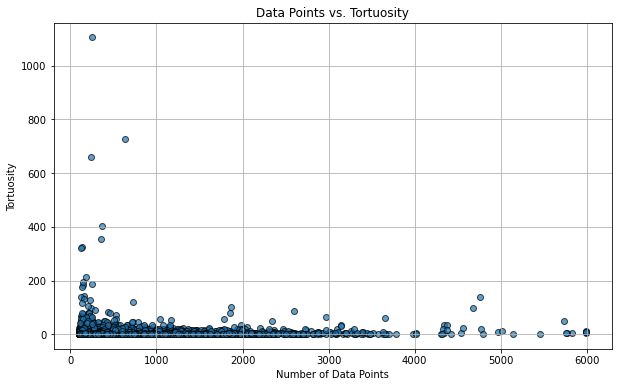

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_tortuosity(file_path):
    """
    Calculates the tortuosity of the path in the given file.
    
    Parameters:
    - file_path: Path to the file containing the track data.

    Returns:
    - tortuosity: Path tortuosity (path length / displacement).
    """
    # Read the data from the file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Extract smoothed positions
    x_smooth = data['x_smooth'].to_numpy()
    y_smooth = data['y_smooth'].to_numpy()
    z_smooth = data['z_smooth'].to_numpy()
    
    # Calculate total path length (Euclidean distance)
    path_length = np.sum(np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2 + np.diff(z_smooth)**2))
    
    # Calculate displacement
    start_point = np.array([x_smooth[0], y_smooth[0], z_smooth[0]])
    end_point = np.array([x_smooth[-1], y_smooth[-1], z_smooth[-1]])
    displacement = np.linalg.norm(end_point - start_point)
    
    # Calculate tortuosity
    tortuosity = path_length / displacement if displacement != 0 else np.nan  # Handle division by zero
    return tortuosity

def analyze_directory(directory_path):
    """
    Calculates the number of data points and tortuosity for each file in a directory,
    then plots the results.

    Parameters:
    - directory_path: Path to the directory containing the files.
    """
    # Get all text files in the directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]

    data_points = []
    tortuosities = []

    for file_path in files:
        try:
            # Read the file to count rows
            data = pd.read_csv(file_path, delim_whitespace=True, header=None)
            num_rows = len(data)
            data_points.append(num_rows)

            # Calculate tortuosity
            tortuosity = calculate_tortuosity(file_path)
            tortuosities.append(tortuosity)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Plot data points vs. tortuosity
    plt.figure(figsize=(10, 6))
    plt.scatter(data_points, tortuosities, alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Data Points')
    plt.ylabel('Tortuosity')
    plt.title('Data Points vs. Tortuosity')
    plt.grid(True)
    plt.show()

# Example Usage
directory_path = "FINALDATA/WT_planktonic_final/"  # Replace with your directory path
analyze_directory(directory_path)


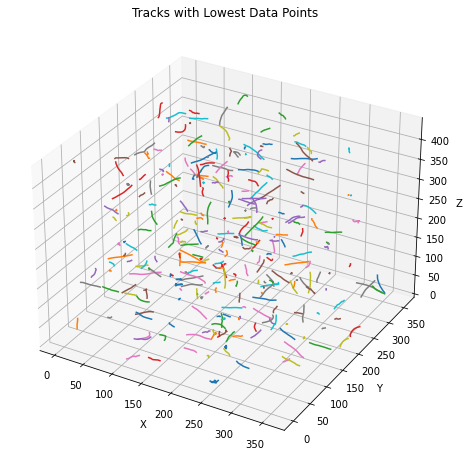

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def calculate_data_points(file_path):
    """
    Counts the number of data points (rows) in the file.

    Parameters:
    - file_path: Path to the file.

    Returns:
    - num_rows: Number of rows (data points) in the file.
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    return len(data)

def plot_lowest_data_point_tracks(directory_path, num_tracks):
    """
    Identifies and plots tracks with the lowest number of data points.

    Parameters:
    - directory_path: Path to the directory containing the files.
    - num_tracks: Number of tracks with the lowest data points to plot.
    """
    # Get all text files in the directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]

    # Calculate data points for each file
    data_points = [(file_path, calculate_data_points(file_path)) for file_path in files]

    # Sort files by the number of data points in ascending order
    sorted_files = sorted(data_points, key=lambda x: x[1])[:num_tracks]

    # Plot tracks with the lowest data points
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for file_path, num_rows in sorted_files:
        data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                           names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
        x = data['x_smooth']
        y = data['y_smooth']
        z = data['z_smooth']

        ax.plot(x, y, z, label=f'{os.path.basename(file_path)} ({num_rows} points)')

    # Configure plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Tracks with Lowest Data Points')

    plt.show()

# Example Usage
directory_path = "FINALDATA/WT_planktonic_final/"  # Replace with your directory path
plot_lowest_data_point_tracks(directory_path, num_tracks=300)


In [30]:
import os
import shutil
import pandas as pd
import numpy as np

def calculate_tortuosity(file_path):
    """
    Calculates the tortuosity of the path in the given file.

    Parameters:
    - file_path: Path to the file containing the track data.

    Returns:
    - tortuosity: Path tortuosity (path length / displacement).
    """
    # Read the data from the file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Extract smoothed positions
    x_smooth = data['x_smooth'].to_numpy()
    y_smooth = data['y_smooth'].to_numpy()
    z_smooth = data['z_smooth'].to_numpy()
    
    # Calculate total path length (Euclidean distance)
    path_length = np.sum(np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2 + np.diff(z_smooth)**2))
    
    # Calculate displacement
    start_point = np.array([x_smooth[0], y_smooth[0], z_smooth[0]])
    end_point = np.array([x_smooth[-1], y_smooth[-1], z_smooth[-1]])
    displacement = np.linalg.norm(end_point - start_point)
    
    # Calculate tortuosity
    tortuosity = path_length / displacement if displacement != 0 else np.nan  # Handle division by zero
    return tortuosity

def move_high_tortuosity_files(directory_path, output_directory, threshold):
    """
    Moves files with tortuosity above a certain threshold to a new directory.

    Parameters:
    - directory_path: Path to the directory containing input files.
    - output_directory: Path to the directory where high tortuosity files will be moved.
    - threshold: Tortuosity threshold above which files will be moved.
    """
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Get all text files in the directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]

    for file_path in files:
        try:
            # Calculate tortuosity
            tortuosity = calculate_tortuosity(file_path)
            
            # Move file if tortuosity exceeds the threshold
            if tortuosity > threshold:
                shutil.move(file_path, os.path.join(output_directory, os.path.basename(file_path)))
                print(f"Moved: {file_path} (Tortuosity: {tortuosity:.2f})")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Example Usage
directory_path = "FINALDATA/Split_Data/Evolved+disk/EDS/"  # Replace with the path to your input directory
output_directory = "FINALDATA/Split_Data/Evolved+disk/OMIT"  # Replace with the path to your output directory
tortuosity_threshold = 1.5  # Replace with your desired tortuosity threshold

move_high_tortuosity_files(directory_path, output_directory, tortuosity_threshold)


Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114604_0_processed.txt (Tortuosity: 2.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track13603_0_processed.txt (Tortuosity: 3.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127026_0_processed.txt (Tortuosity: 1.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track82764_0_processed.txt (Tortuosity: 9.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21258_0_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72741_0_processed.txt (Tortuosity: 8.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track91719_4_processed.txt (Tortuosity: 4.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track94757_0_processed.txt (Tortuosity: 2.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track122144_0_processed.txt (Tortuosity: 2.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56052_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track129798_0_processed.txt (Tortuosity: 7

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29133_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track33615_0_processed.txt (Tortuosity: 4.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19558_0_processed.txt (Tortuosity: 2.05)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98727_0_processed.txt (Tortuosity: 5.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127697_0_processed.txt (Tortuosity: 6.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114774_0 (2)_processed.txt (Tortuosity: 2.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track483_0 (2)_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track129252_0_processed.txt (Tortuosity: 4.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track155684_0_processed.txt (Tortuosity: 3.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track75342_0_processed.txt (Tortuosity: 1.62)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21709_0_processed.txt (Tortuos

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20330_0 (2)_processed.txt (Tortuosity: 4.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track422_0_processed.txt (Tortuosity: 8.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track52964_2_processed.txt (Tortuosity: 2.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131791_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20811_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track171230_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track181215_0_processed.txt (Tortuosity: 2.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track108464_0_processed.txt (Tortuosity: 2.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15345_0_processed.txt (Tortuosity: 1.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track57329_1_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56422_2_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track31734_0_processed.txt (Tortuosity: 2.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track89569_1_processed.txt (Tortuosity: 5.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track167864_0_processed.txt (Tortuosity: 4.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track90846_0_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95924_0_processed.txt (Tortuosity: 2.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7129_0_processed.txt (Tortuosity: 1.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track106926_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56097_0_processed.txt (Tortuosity: 16.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track24770_1_processed.txt (Tortuosity: 2.91)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58452_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track83917_0_processed.txt (Tortuosity: 4.4

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21899_0_processed.txt (Tortuosity: 2.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track106853_7_processed.txt (Tortuosity: 3.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43872_0_processed.txt (Tortuosity: 2.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track129628_7_processed.txt (Tortuosity: 2.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44160_1_processed.txt (Tortuosity: 7.22)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7402_0_processed.txt (Tortuosity: 10.39)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127907_0_processed.txt (Tortuosity: 1.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68326_0 (2)_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50577_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track175233_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56726_0 (2)_processed.txt (Tortu

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track166407_0_processed.txt (Tortuosity: 6.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85872_0_processed.txt (Tortuosity: 5.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track146094_0_processed.txt (Tortuosity: 3.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track108362_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71463_0_processed.txt (Tortuosity: 1.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track46056_12_processed.txt (Tortuosity: 4.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track289_0 (3)_processed.txt (Tortuosity: 3.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98129_0_processed.txt (Tortuosity: 6.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104511_2_processed.txt (Tortuosity: 3.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track52159_0_processed.txt (Tortuosity: 9.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104797_0_processed.txt (Tortuosit

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141479_0_processed.txt (Tortuosity: 3.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track16875_9_processed.txt (Tortuosity: 1.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track97151_0_processed.txt (Tortuosity: 13.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28380_0_processed.txt (Tortuosity: 2.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track176140_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track41978_0_processed.txt (Tortuosity: 2.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track115176_0 (2)_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track39335_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28254_0_processed.txt (Tortuosity: 2.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104037_0 (2)_processed.txt (Tortuosity: 1.91)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track202316_0_processed.txt (Tor

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11845_0_processed.txt (Tortuosity: 1.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track52210_0_processed.txt (Tortuosity: 2.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29820_0_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track218069_0_processed.txt (Tortuosity: 4.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96911_0_processed.txt (Tortuosity: 5.19)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track184_0_processed.txt (Tortuosity: 2.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track67719_0_processed.txt (Tortuosity: 5.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track8609_0_processed.txt (Tortuosity: 2.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77855_0_processed.txt (Tortuosity: 2.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9790_0_processed.txt (Tortuosity: 1.77)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64764_0_processed.txt (Tortuosity: 13.06)
M

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65055_0_processed.txt (Tortuosity: 3.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track39010_0_processed.txt (Tortuosity: 2.01)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track124731_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track3732_0_processed.txt (Tortuosity: 3.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track26654_0_processed.txt (Tortuosity: 2.05)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56597_0_processed.txt (Tortuosity: 1.75)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71056_0_processed.txt (Tortuosity: 5.26)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track164379_0_processed.txt (Tortuosity: 4.77)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track128267_6_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track102280_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95199_0_processed.txt (Tortuosity: 2.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track39495_0_processed.txt (Tortuosity: 3.33)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58637_0_processed.txt (Tortuosity: 5.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track194439_0_processed.txt (Tortuosity: 3.77)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track87869_0_processed.txt (Tortuosity: 1.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19006_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track150291_2_processed.txt (Tortuosity: 22.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track144014_0_processed.txt (Tortuosity: 2.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track89383_0_processed.txt (Tortuosity: 2.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43_0_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85496_0_processed.txt (Tortuosity: 1.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63480_0_processed.txt (Tortuosity: 1.66

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29558_0_processed.txt (Tortuosity: 4.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track76754_0_processed.txt (Tortuosity: 4.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track160986_0_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track94459_0_processed.txt (Tortuosity: 6.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track97610_0_processed.txt (Tortuosity: 22.34)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track111468_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track60767_0_processed.txt (Tortuosity: 3.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track92492_0_processed.txt (Tortuosity: 4.08)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68089_0_processed.txt (Tortuosity: 1.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track32007_0_processed.txt (Tortuosity: 7.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64828_0_processed.txt (Tortuosity: 2.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track174228_0_processed.txt (Tortuosity: 3.46)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96070_0_processed.txt (Tortuosity: 2.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116123_0_processed.txt (Tortuosity: 1.94)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29141_0_processed.txt (Tortuosity: 2.13)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track152590_0_processed.txt (Tortuosity: 31.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50715_0_processed.txt (Tortuosity: 6.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track103359_0_processed.txt (Tortuosity: 3.31)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72056_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track74006_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28043_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track139559_0 (2)_processed.txt (Tortuos

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21059_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114851_0_processed.txt (Tortuosity: 2.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track23389_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66425_2_processed.txt (Tortuosity: 2.94)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100852_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track159521_0_processed.txt (Tortuosity: 3.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43352_0_processed.txt (Tortuosity: 3.12)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64693_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107900_0_processed.txt (Tortuosity: 12.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61411_0_processed.txt (Tortuosity: 1.91)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track91600_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141850_0_processed.txt (Tortuosity: 1.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11201_0_processed.txt (Tortuosity: 1.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track80086_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63212_0_processed.txt (Tortuosity: 3.44)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track25571_0_processed.txt (Tortuosity: 22.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79534_0_processed.txt (Tortuosity: 13.09)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18796_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track136921_0_processed.txt (Tortuosity: 2.33)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71692_0 (2)_processed.txt (Tortuosity: 5.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40948_0_processed.txt (Tortuosity: 3.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track163173_0_processed.txt (Tortuosi

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track48_0 (2)_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track179689_0_processed.txt (Tortuosity: 8.26)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15369_0_processed.txt (Tortuosity: 2.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track46670_0_processed.txt (Tortuosity: 1.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track123928_0_processed.txt (Tortuosity: 3.77)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30578_0_processed.txt (Tortuosity: 2.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track22588_0 (2)_processed.txt (Tortuosity: 11.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141677_0_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17359_0_processed.txt (Tortuosity: 2.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40797_4_processed.txt (Tortuosity: 3.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track124120_0 (2)_processed.txt (Tor

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68001_0 (2)_processed.txt (Tortuosity: 15.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21007_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track115622_0_processed.txt (Tortuosity: 1.69)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track111539_0_processed.txt (Tortuosity: 2.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track31199_2_processed.txt (Tortuosity: 1.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track129908_0_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56176_0_processed.txt (Tortuosity: 8.93)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track10615_0_processed.txt (Tortuosity: 3.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track8594_0_processed.txt (Tortuosity: 2.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track87459_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track92417_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track329_1_processed.txt (Tortuosity: 2.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98739_0_processed.txt (Tortuosity: 1.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30442_0_processed.txt (Tortuosity: 7.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40781_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track67240_0_processed.txt (Tortuosity: 3.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17263_0_processed.txt (Tortuosity: 5.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track3943_0_processed.txt (Tortuosity: 5.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track42805_0_processed.txt (Tortuosity: 16.36)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88421_0_processed.txt (Tortuosity: 3.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113219_0_processed.txt (Tortuosity: 2.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track123186_1_processed.txt (Tortuosity: 7.51)

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116896_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track51241_4_processed.txt (Tortuosity: 4.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track93713_0_processed.txt (Tortuosity: 1.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track185675_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11891_0_processed.txt (Tortuosity: 2.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107643_0_processed.txt (Tortuosity: 2.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79224_0_processed.txt (Tortuosity: 2.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77955_0_processed.txt (Tortuosity: 12.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track219310_0_processed.txt (Tortuosity: 2.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96811_0_processed.txt (Tortuosity: 23.27)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116942_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track78895_0_processed.txt (Tortuosity: 1.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17146_0_processed.txt (Tortuosity: 1.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113630_5_processed.txt (Tortuosity: 2.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track23982_0_processed.txt (Tortuosity: 3.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track315_0 (2)_processed.txt (Tortuosity: 3.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140611_0_processed.txt (Tortuosity: 2.31)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68742_0_processed.txt (Tortuosity: 3.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track136582_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track23919_0_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9297_0_processed.txt (Tortuosity: 2.17)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track133700_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track162918_0_processed.txt (Tortuosity: 1.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track25103_0_processed.txt (Tortuosity: 5.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track13643_0_processed.txt (Tortuosity: 2.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track8998_0 (2)_processed.txt (Tortuosity: 4.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track142144_0_processed.txt (Tortuosity: 2.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104627_0_processed.txt (Tortuosity: 2.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track337_6_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track39595_0_processed.txt (Tortuosity: 1.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track92995_2_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65630_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27248_0_processed.txt (Tortuosity: 2

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66403_0_processed.txt (Tortuosity: 1.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140195_0_processed.txt (Tortuosity: 20.09)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track49275_0 (2)_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track117823_0_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track154276_0_processed.txt (Tortuosity: 3.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116778_0 (2)_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40272_0 (2)_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95940_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track6334_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track78223_2_processed.txt (Tortuosity: 26.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track165464_0_processed.txt 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95801_0_processed.txt (Tortuosity: 3.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track160447_0_processed.txt (Tortuosity: 2.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track147266_0_processed.txt (Tortuosity: 2.27)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track35320_0_processed.txt (Tortuosity: 7.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track149917_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104833_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27008_0_processed.txt (Tortuosity: 2.09)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43028_0_processed.txt (Tortuosity: 4.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track123246_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17463_0_processed.txt (Tortuosity: 2.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track60946_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96974_0_processed.txt (Tortuosity: 2.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100440_0_processed.txt (Tortuosity: 2.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9841_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44246_0_processed.txt (Tortuosity: 2.80)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track219195_0_processed.txt (Tortuosity: 4.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113511_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track109023_0 (3)_processed.txt (Tortuosity: 2.22)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11820_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track62685_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17870_0_processed.txt (Tortuosity: 2.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track12546_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track136286_0 (2)_processed.txt (Tortuosity: 2.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track118931_0_processed.txt (Tortuosity: 1.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track48080_0_processed.txt (Tortuosity: 1.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track215353_0_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track57524_0_processed.txt (Tortuosity: 13.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track46445_0_processed.txt (Tortuosity: 3.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track157471_0_processed.txt (Tortuosity: 2.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100273_0_processed.txt (Tortuosity: 2.12)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track74365_0_processed.txt (Tortuosity: 2.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track184215_0_processed.txt (Tortuosity: 2.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56426_0_processed.txt (Tortuo

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track1344_0_processed.txt (Tortuosity: 3.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track112863_0_processed.txt (Tortuosity: 5.45)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track37093_0_processed.txt (Tortuosity: 3.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61230_5_processed.txt (Tortuosity: 4.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65488_0_processed.txt (Tortuosity: 17.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68204_0_processed.txt (Tortuosity: 6.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64511_0_processed.txt (Tortuosity: 3.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113961_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track70946_0_processed.txt (Tortuosity: 57.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track33313_0_processed.txt (Tortuosity: 1.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11450_0_processed.txt (Tortuosity: 3.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track121798_0_processed.txt (Tortuosity: 3.18)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58099_0_processed.txt (Tortuosity: 2.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track143773_0_processed.txt (Tortuosity: 1.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63596_0 (2)_processed.txt (Tortuosity: 3.31)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127753_0_processed.txt (Tortuosity: 3.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track13176_0_processed.txt (Tortuosity: 6.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63155_0_processed.txt (Tortuosity: 15.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track16014_0_processed.txt (Tortuosity: 2.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47969_0_processed.txt (Tortuosity: 2.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track133750_0_processed.txt (Tortuosity: 3.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95211_6_processed.txt (Tortuosi

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85787_0_processed.txt (Tortuosity: 1.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66513_0_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track55331_0_processed.txt (Tortuosity: 1.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18215_0_processed.txt (Tortuosity: 5.69)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56178_0_processed.txt (Tortuosity: 17.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61441_0_processed.txt (Tortuosity: 5.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30168_0_processed.txt (Tortuosity: 3.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56298_0_processed.txt (Tortuosity: 2.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15779_0_processed.txt (Tortuosity: 2.27)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track135224_0_processed.txt (Tortuosity: 3.26)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track162426_0_processed.txt (Tortuosity: 2.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track174036_0_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track220893_0_processed.txt (Tortuosity: 5.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track156775_0_processed.txt (Tortuosity: 5.46)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track70278_0_processed.txt (Tortuosity: 2.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101177_0_processed.txt (Tortuosity: 1.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track35752_0_processed.txt (Tortuosity: 6.36)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20528_0_processed.txt (Tortuosity: 1.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track99886_0_processed.txt (Tortuosity: 4.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64976_0 (2)_processed.txt (Tortuosity: 10.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track153617_0_processed.txt (Tortuosity: 2.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track76153_0_processed.txt (Tortuos

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9962_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track134213_0_processed.txt (Tortuosity: 2.18)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track38453_0_processed.txt (Tortuosity: 1.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track93935_0_processed.txt (Tortuosity: 9.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track172924_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track132138_0_processed.txt (Tortuosity: 3.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131371_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track5223_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track191404_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27217_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track125092_0_processed.txt (Tortuosity: 1

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131639_0_processed.txt (Tortuosity: 3.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track48138_0_processed.txt (Tortuosity: 1.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19845_0_processed.txt (Tortuosity: 2.01)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72158_0 (2)_processed.txt (Tortuosity: 3.24)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28203_0_processed.txt (Tortuosity: 3.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140783_0_processed.txt (Tortuosity: 4.09)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140837_0_processed.txt (Tortuosity: 1.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track119544_0_processed.txt (Tortuosity: 1.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track4512_0_processed.txt (Tortuosity: 2.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track45454_0_processed.txt (Tortuosity: 1.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track57853_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72981_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79072_0_processed.txt (Tortuosity: 6.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track90885_0_processed.txt (Tortuosity: 2.39)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track126122_0_processed.txt (Tortuosity: 2.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98817_0 (2)_processed.txt (Tortuosity: 2.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track128607_0_processed.txt (Tortuosity: 2.24)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track109396_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101798_0_processed.txt (Tortuosity: 2.13)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120292_0_processed.txt (Tortuosity: 5.93)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track182637_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track111760_0_processed.txt (Tortuo

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58644_0_processed.txt (Tortuosity: 1.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track4176_0_processed.txt (Tortuosity: 3.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track37023_0_processed.txt (Tortuosity: 4.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track22259_0_processed.txt (Tortuosity: 3.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track112553_0_processed.txt (Tortuosity: 2.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28807_0_processed.txt (Tortuosity: 4.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track142704_0 (2)_processed.txt (Tortuosity: 1.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track82718_0_processed.txt (Tortuosity: 2.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track137342_0_processed.txt (Tortuosity: 16.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track92379_0 (3)_processed.txt (Tortuosity: 3.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track93679_0_processed.txt (Tortuo

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66442_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track5247_0_processed.txt (Tortuosity: 2.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track89223_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track119068_0_processed.txt (Tortuosity: 3.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77658_0_processed.txt (Tortuosity: 2.12)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28454_0_processed.txt (Tortuosity: 3.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7170_0 (2)_processed.txt (Tortuosity: 2.05)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track108192_0_processed.txt (Tortuosity: 3.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track165425_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track52165_4_processed.txt (Tortuosity: 3.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track139834_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100432_0_processed.txt (Tortuosity: 2.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track193_0_processed.txt (Tortuosity: 4.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track5372_0_processed.txt (Tortuosity: 2.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track75872_0_processed.txt (Tortuosity: 4.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15586_70_processed.txt (Tortuosity: 2.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131220_0_processed.txt (Tortuosity: 5.06)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track132069_0_processed.txt (Tortuosity: 3.93)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127213_0_processed.txt (Tortuosity: 1.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61611_0_processed.txt (Tortuosity: 2.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track138583_0_processed.txt (Tortuosity: 1.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77996_0_processed.txt (Tortuosity: 5.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61232_0_processed.txt (Tortuosity: 2.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track155417_0_processed.txt (Tortuosity: 2.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track201306_0_processed.txt (Tortuosity: 2.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98780_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track128158_0_processed.txt (Tortuosity: 2.40)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track139039_0_processed.txt (Tortuosity: 4.13)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track118582_0 (2)_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track830_0_processed.txt (Tortuosity: 3.34)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track172236_0_processed.txt (Tortuosity: 3.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131863_0_processed.txt (Tortuosity: 7.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track37649_0_processed.txt (Tortuosi

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track132975_0_processed.txt (Tortuosity: 1.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track163008_0_processed.txt (Tortuosity: 2.32)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track54464_0_processed.txt (Tortuosity: 3.08)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track109476_0_processed.txt (Tortuosity: 5.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track48312_0_processed.txt (Tortuosity: 2.19)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track80352_0_processed.txt (Tortuosity: 3.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44407_0_processed.txt (Tortuosity: 10.01)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track22003_1_processed.txt (Tortuosity: 2.03)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18442_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34424_0_processed.txt (Tortuosity: 1.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27847_2_processed.txt (Tortuosity: 3

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140282_0 (3)_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track82695_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track82921_0_processed.txt (Tortuosity: 1.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track14540_0_processed.txt (Tortuosity: 3.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141289_0 (2)_processed.txt (Tortuosity: 3.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track213932_0_processed.txt (Tortuosity: 3.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95996_0 (2)_processed.txt (Tortuosity: 3.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track37301_0_processed.txt (Tortuosity: 23.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track112445_0_processed.txt (Tortuosity: 2.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track138708_0_processed.txt (Tortuosity: 2.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77749_0_processed.txt 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track102513_0_processed.txt (Tortuosity: 4.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120250_0_processed.txt (Tortuosity: 2.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track123019_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131331_0_processed.txt (Tortuosity: 1.69)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track208197_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track2331_0_processed.txt (Tortuosity: 2.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63950_0_processed.txt (Tortuosity: 2.41)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100977_0_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85512_0_processed.txt (Tortuosity: 2.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track200679_0_processed.txt (Tortuosity: 2.40)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track148931_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track41294_0_processed.txt (Tortuosity: 2.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track60705_0_processed.txt (Tortuosity: 1.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track93569_0_processed.txt (Tortuosity: 3.80)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58480_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track115971_0_processed.txt (Tortuosity: 10.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track24262_0_processed.txt (Tortuosity: 1.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17440_0_processed.txt (Tortuosity: 2.39)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track8693_0_processed.txt (Tortuosity: 2.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58900_0_processed.txt (Tortuosity: 2.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track99363_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track83445_0_processed.txt (Tortuosity: 2.52

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107677_0_processed.txt (Tortuosity: 1.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114332_1_processed.txt (Tortuosity: 3.45)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98160_0_processed.txt (Tortuosity: 3.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113594_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track53369_0_processed.txt (Tortuosity: 2.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track39906_0 (2)_processed.txt (Tortuosity: 2.39)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track94713_2_processed.txt (Tortuosity: 2.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track136385_0_processed.txt (Tortuosity: 3.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88198_0_processed.txt (Tortuosity: 3.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track219110_0_processed.txt (Tortuosity: 2.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track36228_4_processed.txt (Tortuosi

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145483_0_processed.txt (Tortuosity: 2.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11394_0_processed.txt (Tortuosity: 6.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101239_0_processed.txt (Tortuosity: 2.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track601_0_processed.txt (Tortuosity: 2.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track73219_2_processed.txt (Tortuosity: 2.40)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track155186_1_processed.txt (Tortuosity: 2.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track152720_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track205278_0_processed.txt (Tortuosity: 4.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track133582_0_processed.txt (Tortuosity: 4.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63067_0_processed.txt (Tortuosity: 2.08)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track373_3_processed.txt (Tortuosity: 9.2

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20055_0_processed.txt (Tortuosity: 8.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58703_0_processed.txt (Tortuosity: 2.17)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track42025_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track119067_0_processed.txt (Tortuosity: 74.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100508_0_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track51294_0_processed.txt (Tortuosity: 2.62)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track12775_0_processed.txt (Tortuosity: 4.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track137031_0_processed.txt (Tortuosity: 4.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68088_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65604_0_processed.txt (Tortuosity: 5.03)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track158782_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track70213_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85740_1_processed.txt (Tortuosity: 2.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7841_0_processed.txt (Tortuosity: 2.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66220_0_processed.txt (Tortuosity: 3.41)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50680_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track94235_0_processed.txt (Tortuosity: 25.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50560_0_processed.txt (Tortuosity: 1.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7415_0_processed.txt (Tortuosity: 1.69)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79464_0_processed.txt (Tortuosity: 2.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track37709_0_processed.txt (Tortuosity: 3.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track196284_0_processed.txt (Tortuosity: 2.81)

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track201566_3_processed.txt (Tortuosity: 6.01)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track119093_0 (2)_processed.txt (Tortuosity: 1.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track36722_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track109740_0_processed.txt (Tortuosity: 2.26)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track132216_0 (2)_processed.txt (Tortuosity: 2.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131725_0_processed.txt (Tortuosity: 5.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track118995_0_processed.txt (Tortuosity: 2.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56999_0_processed.txt (Tortuosity: 2.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track106028_0_processed.txt (Tortuosity: 4.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track1758_0_processed.txt (Tortuosity: 1.62)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track33794_0_processed.txt (Tor

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107960_0_processed.txt (Tortuosity: 2.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11806_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85803_0_processed.txt (Tortuosity: 3.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track117998_0_processed.txt (Tortuosity: 2.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track136326_0_processed.txt (Tortuosity: 1.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track2274_0_processed.txt (Tortuosity: 7.45)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track217576_0_processed.txt (Tortuosity: 2.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track105504_0_processed.txt (Tortuosity: 3.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track91800_0_processed.txt (Tortuosity: 3.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44180_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track158738_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track85936_0_processed.txt (Tortuosity: 10.46)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track16861_0_processed.txt (Tortuosity: 2.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34096_0_processed.txt (Tortuosity: 2.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track164693_0_processed.txt (Tortuosity: 16.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114550_0_processed.txt (Tortuosity: 7.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track111866_0_processed.txt (Tortuosity: 5.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track159474_0_processed.txt (Tortuosity: 2.45)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track206522_0_processed.txt (Tortuosity: 8.69)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11687_0_processed.txt (Tortuosity: 2.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29956_0_processed.txt (Tortuosity: 3.02)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track312_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9804_0_processed.txt (Tortuosity: 1.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track129501_0_processed.txt (Tortuosity: 4.26)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track161913_0_processed.txt (Tortuosity: 3.18)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track134375_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track87850_0_processed.txt (Tortuosity: 2.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track14907_0_processed.txt (Tortuosity: 2.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96931_0_processed.txt (Tortuosity: 3.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track135842_0 (2)_processed.txt (Tortuosity: 2.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track59797_0_processed.txt (Tortuosity: 4.06)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track102861_0_processed.txt (Tortuosity: 2.09)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113900_0_processed.txt (Tortuosi

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95726_1_processed.txt (Tortuosity: 5.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track181264_0_processed.txt (Tortuosity: 2.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track336_0 (2)_processed.txt (Tortuosity: 5.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track83758_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track219197_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track143243_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88427_5_processed.txt (Tortuosity: 9.43)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107510_0_processed.txt (Tortuosity: 5.12)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141273_0_processed.txt (Tortuosity: 12.13)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track4480_0 (2)_processed.txt (Tortuosity: 2.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29413_0_processed.txt (Tortuo

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15093_0_processed.txt (Tortuosity: 1.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140414_0_processed.txt (Tortuosity: 6.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track112374_0_processed.txt (Tortuosity: 2.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track3437_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track199961_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track69811_0_processed.txt (Tortuosity: 3.13)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107195_0_processed.txt (Tortuosity: 4.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track87326_0_processed.txt (Tortuosity: 2.06)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9_0 (2)_processed.txt (Tortuosity: 2.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track36532_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9372_0_processed.txt (Tortuosity: 3.6

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116984_0_processed.txt (Tortuosity: 2.44)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104518_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track55570_1_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track150153_0_processed.txt (Tortuosity: 1.77)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34026_0_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track25147_0_processed.txt (Tortuosity: 5.27)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track62589_0_processed.txt (Tortuosity: 2.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track13867_0_processed.txt (Tortuosity: 1.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66840_2_processed.txt (Tortuosity: 4.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track148825_0_processed.txt (Tortuosity: 1.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64916_0_processed.txt (Tortuosity: 3

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7680_6_processed.txt (Tortuosity: 3.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track99586_0_processed.txt (Tortuosity: 1.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98370_1_processed.txt (Tortuosity: 6.01)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track14692_0 (2)_processed.txt (Tortuosity: 1.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track42858_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track165378_0_processed.txt (Tortuosity: 2.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29290_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track480_0_processed.txt (Tortuosity: 2.77)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29170_0_processed.txt (Tortuosity: 2.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track80392_0_processed.txt (Tortuosity: 6.93)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track138144_0_processed.txt (Tortuosity: 1.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track39652_0_processed.txt (Tortuosity: 3.32)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track84193_0 (2)_processed.txt (Tortuosity: 4.17)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track142283_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track84046_0 (2)_processed.txt (Tortuosity: 2.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95986_0_processed.txt (Tortuosity: 2.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track158645_0_processed.txt (Tortuosity: 3.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track3016_2_processed.txt (Tortuosity: 1.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track108115_0_processed.txt (Tortuosity: 2.12)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track86763_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9635_0_processed.txt (Tortuosity: 2.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114663_0_processed.txt (Tortuos

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101295_0_processed.txt (Tortuosity: 6.36)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19650_2_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track209621_0_processed.txt (Tortuosity: 8.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56996_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17935_3_processed.txt (Tortuosity: 5.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track74161_0_processed.txt (Tortuosity: 4.94)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track110932_3_processed.txt (Tortuosity: 3.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track33022_0_processed.txt (Tortuosity: 3.39)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track102765_0_processed.txt (Tortuosity: 2.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track216868_0_processed.txt (Tortuosity: 7.94)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track210717_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120631_0_processed.txt (Tortuosity: 5.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track38392_0_processed.txt (Tortuosity: 1.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track102292_0_processed.txt (Tortuosity: 3.36)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50747_0_processed.txt (Tortuosity: 6.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track107219_0_processed.txt (Tortuosity: 1.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15064_0_processed.txt (Tortuosity: 1.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track224479_0_processed.txt (Tortuosity: 5.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track151662_0_processed.txt (Tortuosity: 2.32)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track73074_0_processed.txt (Tortuosity: 2.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track137509_0_processed.txt (Tortuosity: 14.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43484_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96354_1_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track74819_0_processed.txt (Tortuosity: 1.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track151433_0 (2)_processed.txt (Tortuosity: 1.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track136160_0_processed.txt (Tortuosity: 51.22)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96740_0_processed.txt (Tortuosity: 1.51)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track223040_0_processed.txt (Tortuosity: 2.34)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track45550_9_processed.txt (Tortuosity: 1.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track110538_0_processed.txt (Tortuosity: 3.36)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101459_0_processed.txt (Tortuosity: 7.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track184709_0_processed.txt (Tortuosity: 2.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track11152_3_processed.txt (Tortuo

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track187119_0_processed.txt (Tortuosity: 3.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track53855_0_processed.txt (Tortuosity: 2.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145687_0_processed.txt (Tortuosity: 6.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track128330_0_processed.txt (Tortuosity: 6.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71630_3_processed.txt (Tortuosity: 1.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track8181_0_processed.txt (Tortuosity: 3.03)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track110355_0_processed.txt (Tortuosity: 4.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27739_0_processed.txt (Tortuosity: 4.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30927_0_processed.txt (Tortuosity: 1.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98608_0_processed.txt (Tortuosity: 10.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track54553_0_processed.txt (Tortuosity: 1

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track74413_0_processed.txt (Tortuosity: 37.75)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track103863_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47231_0_processed.txt (Tortuosity: 5.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track108190_0_processed.txt (Tortuosity: 6.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track104685_0_processed.txt (Tortuosity: 2.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95557_0_processed.txt (Tortuosity: 2.02)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61669_0_processed.txt (Tortuosity: 4.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track156205_0_processed.txt (Tortuosity: 2.12)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track4293_0_processed.txt (Tortuosity: 4.41)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track156031_0_processed.txt (Tortuosity: 7.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track137293_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127441_0_processed.txt (Tortuosity: 1.62)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44466_0_processed.txt (Tortuosity: 1.62)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131646_0_processed.txt (Tortuosity: 5.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18617_0_processed.txt (Tortuosity: 5.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track55887_0_processed.txt (Tortuosity: 4.42)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64893_0 (2)_processed.txt (Tortuosity: 10.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65358_0_processed.txt (Tortuosity: 4.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track133596_0_processed.txt (Tortuosity: 4.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66111_0_processed.txt (Tortuosity: 2.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9001_0_processed.txt (Tortuosity: 2.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track124868_0_processed.txt (Tortuosit

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track46757_0_processed.txt (Tortuosity: 1.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track16007_0_processed.txt (Tortuosity: 3.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track3959_0 (2)_processed.txt (Tortuosity: 11.44)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track2493_0_processed.txt (Tortuosity: 3.93)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track133743_0_processed.txt (Tortuosity: 3.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track4458_0_processed.txt (Tortuosity: 1.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track157763_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track80032_0_processed.txt (Tortuosity: 4.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101318_0_processed.txt (Tortuosity: 2.33)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track127549_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34919_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68914_0_processed.txt (Tortuosity: 2.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track122783_0_processed.txt (Tortuosity: 1.62)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track103289_0_processed.txt (Tortuosity: 3.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track48233_0_processed.txt (Tortuosity: 4.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track144473_0_processed.txt (Tortuosity: 1.80)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track24932_0_processed.txt (Tortuosity: 4.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95513_0 (2)_processed.txt (Tortuosity: 3.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145691_0_processed.txt (Tortuosity: 3.02)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track2649_0_processed.txt (Tortuosity: 3.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track105139_0_processed.txt (Tortuosity: 2.94)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30931_0_processed.txt (Tortuosit

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track132_1_processed.txt (Tortuosity: 4.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track41403_0_processed.txt (Tortuosity: 1.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track2695_0_processed.txt (Tortuosity: 1.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63340_0_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72347_2_processed.txt (Tortuosity: 2.08)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116354_0_processed.txt (Tortuosity: 21.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30659_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120840_0_processed.txt (Tortuosity: 2.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track57864_0_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track75093_0_processed.txt (Tortuosity: 1.95)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track157931_0_processed.txt (Tortuosity: 1.55

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track124225_0 (2)_processed.txt (Tortuosity: 2.35)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track36023_0_processed.txt (Tortuosity: 2.34)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43162_0_processed.txt (Tortuosity: 3.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track23481_5_processed.txt (Tortuosity: 8.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track142328_2_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50033_0_processed.txt (Tortuosity: 1.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100982_0_processed.txt (Tortuosity: 2.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19515_0 (2)_processed.txt (Tortuosity: 2.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72770_0_processed.txt (Tortuosity: 1.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track82491_0_processed.txt (Tortuosity: 2.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track166602_0_processed.txt (Tortu

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145726_0_processed.txt (Tortuosity: 3.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100297_0_processed.txt (Tortuosity: 2.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track108699_0_processed.txt (Tortuosity: 3.92)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track55610_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79988_6_processed.txt (Tortuosity: 6.36)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71198_0_processed.txt (Tortuosity: 2.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79596_0_processed.txt (Tortuosity: 38.34)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131765_0_processed.txt (Tortuosity: 2.02)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track102147_0_processed.txt (Tortuosity: 2.27)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track142200_9_processed.txt (Tortuosity: 6.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track70001_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track222472_2_processed.txt (Tortuosity: 7.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track135850_0_processed.txt (Tortuosity: 2.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track168638_0_processed.txt (Tortuosity: 1.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track137434_0_processed.txt (Tortuosity: 3.18)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21552_0_processed.txt (Tortuosity: 4.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track75119_0_processed.txt (Tortuosity: 7.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track128190_0_processed.txt (Tortuosity: 4.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track132999_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track54488_0_processed.txt (Tortuosity: 7.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120505_0_processed.txt (Tortuosity: 4.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track17169_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track42248_0 (2)_processed.txt (Tortuosity: 8.14)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20945_0_processed.txt (Tortuosity: 1.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116304_0_processed.txt (Tortuosity: 3.40)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64242_0_processed.txt (Tortuosity: 3.31)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track185253_0_processed.txt (Tortuosity: 3.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track560_0 (2)_processed.txt (Tortuosity: 2.24)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track52679_0_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track69455_0_processed.txt (Tortuosity: 1.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27738_0_processed.txt (Tortuosity: 1.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track81086_0_processed.txt (Tortuosity: 3.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track168499_0_processed.txt (Tortuosi

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40464_0_processed.txt (Tortuosity: 6.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29253_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track189387_1_processed.txt (Tortuosity: 2.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track5916_0_processed.txt (Tortuosity: 4.30)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track64377_0_processed.txt (Tortuosity: 3.22)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track81128_0_processed.txt (Tortuosity: 9.93)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61230_0 (2)_processed.txt (Tortuosity: 3.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120925_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68782_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track111083_0_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track91230_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track86814_0_processed.txt (Tortuosity: 2.22)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88365_0_processed.txt (Tortuosity: 4.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track83522_0_processed.txt (Tortuosity: 2.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track10475_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71963_0_processed.txt (Tortuosity: 1.86)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track76831_0_processed.txt (Tortuosity: 2.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track158932_0_processed.txt (Tortuosity: 5.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track87639_0_processed.txt (Tortuosity: 2.27)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track172550_0_processed.txt (Tortuosity: 6.48)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track79242_0_processed.txt (Tortuosity: 1.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track106588_0_processed.txt (Tortuosity: 2.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track26522_0_processed.txt (Tortuosity: 2.10)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track112307_0_processed.txt (Tortuosity: 3.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100517_5_processed.txt (Tortuosity: 4.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track31681_0_processed.txt (Tortuosity: 1.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9193_0_processed.txt (Tortuosity: 1.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47589_0_processed.txt (Tortuosity: 2.24)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29277_0_processed.txt (Tortuosity: 1.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track38316_0_processed.txt (Tortuosity: 2.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96346_0_processed.txt (Tortuosity: 3.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120555_0_processed.txt (Tortuosity: 5.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track147888_0_processed.txt (Tortuosity: 1.

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track6935_0_processed.txt (Tortuosity: 3.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track111109_0_processed.txt (Tortuosity: 4.24)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track112340_0_processed.txt (Tortuosity: 3.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65084_0_processed.txt (Tortuosity: 11.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58263_0_processed.txt (Tortuosity: 2.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68693_0_processed.txt (Tortuosity: 11.63)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77337_0_processed.txt (Tortuosity: 3.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track131501_0_processed.txt (Tortuosity: 2.96)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track59361_0_processed.txt (Tortuosity: 3.16)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96273_0_processed.txt (Tortuosity: 1.91)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track33464_0_processed.txt (Tortuosity: 3

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track160060_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track155689_0_processed.txt (Tortuosity: 2.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track118819_0_processed.txt (Tortuosity: 2.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track116368_0_processed.txt (Tortuosity: 17.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track146438_0_processed.txt (Tortuosity: 2.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track55494_0 (2)_processed.txt (Tortuosity: 2.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track12532_1_processed.txt (Tortuosity: 8.41)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track169617_0_processed.txt (Tortuosity: 1.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track124733_0_processed.txt (Tortuosity: 8.11)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18518_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track67387_0_processed.txt (Tortu

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track77131_0_processed.txt (Tortuosity: 2.03)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58900_0 (2)_processed.txt (Tortuosity: 6.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track7665_0_processed.txt (Tortuosity: 2.46)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track25458_0_processed.txt (Tortuosity: 9.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track71013_0_processed.txt (Tortuosity: 3.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30622_0_processed.txt (Tortuosity: 5.17)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track90157_0_processed.txt (Tortuosity: 2.71)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track78584_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track28446_3_processed.txt (Tortuosity: 2.46)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101165_0_processed.txt (Tortuosity: 2.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track142484_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track60765_0_processed.txt (Tortuosity: 8.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track90484_0_processed.txt (Tortuosity: 7.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40032_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track95_0 (3)_processed.txt (Tortuosity: 2.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track3665_0 (2)_processed.txt (Tortuosity: 11.25)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track1174_0_processed.txt (Tortuosity: 1.72)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145005_0_processed.txt (Tortuosity: 4.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63508_0_processed.txt (Tortuosity: 5.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113705_0_processed.txt (Tortuosity: 3.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track86878_0_processed.txt (Tortuosity: 3.40)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34071_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140602_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18409_0_processed.txt (Tortuosity: 2.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track99676_0_processed.txt (Tortuosity: 2.20)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47605_0_processed.txt (Tortuosity: 2.02)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30494_0_processed.txt (Tortuosity: 1.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track101033_0_processed.txt (Tortuosity: 3.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track51982_0_processed.txt (Tortuosity: 2.22)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track90001_0_processed.txt (Tortuosity: 6.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track171010_0_processed.txt (Tortuosity: 2.49)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track170189_0_processed.txt (Tortuosity: 3.80)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track99596_0_processed.txt (Tortuosity: 2

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track157866_0_processed.txt (Tortuosity: 1.60)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63217_0_processed.txt (Tortuosity: 2.35)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20842_0_processed.txt (Tortuosity: 3.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44862_0_processed.txt (Tortuosity: 1.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120917_0_processed.txt (Tortuosity: 2.55)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98475_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track6442_0_processed.txt (Tortuosity: 1.61)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19691_0_processed.txt (Tortuosity: 2.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track128236_0_processed.txt (Tortuosity: 5.45)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track139357_0_processed.txt (Tortuosity: 2.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47950_0_processed.txt (Tortuosity: 20

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track87590_0 (2)_processed.txt (Tortuosity: 2.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track476_0_processed.txt (Tortuosity: 2.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track65269_2_processed.txt (Tortuosity: 2.82)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track138386_0_processed.txt (Tortuosity: 1.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30969_0_processed.txt (Tortuosity: 3.43)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21808_0_processed.txt (Tortuosity: 5.31)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27777_0_processed.txt (Tortuosity: 1.75)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track185287_0_processed.txt (Tortuosity: 3.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96163_0_processed.txt (Tortuosity: 2.50)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29052_0_processed.txt (Tortuosity: 20.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track163171_0_processed.txt (Tortuosity:

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track50733_0_processed.txt (Tortuosity: 2.05)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track9283_0_processed.txt (Tortuosity: 15.05)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track63111_0_processed.txt (Tortuosity: 8.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track59436_3_processed.txt (Tortuosity: 1.75)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141707_0_processed.txt (Tortuosity: 1.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track125727_0_processed.txt (Tortuosity: 1.64)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track45549_0_processed.txt (Tortuosity: 4.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track497_0_processed.txt (Tortuosity: 11.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113387_0_processed.txt (Tortuosity: 4.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track46586_2_processed.txt (Tortuosity: 2.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track25592_0_processed.txt (Tortuosity: 2.3

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track25133_0_processed.txt (Tortuosity: 1.69)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track146114_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track125066_0_processed.txt (Tortuosity: 53.68)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track43123_0_processed.txt (Tortuosity: 6.65)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61660_0_processed.txt (Tortuosity: 1.81)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track66886_0_processed.txt (Tortuosity: 5.59)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track198287_0_processed.txt (Tortuosity: 1.54)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track27337_0_processed.txt (Tortuosity: 8.08)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track38693_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34186_0_processed.txt (Tortuosity: 4.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18200_0_processed.txt (Tortuosity: 1

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track105070_0_processed.txt (Tortuosity: 12.28)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track20734_0_processed.txt (Tortuosity: 1.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track113952_0 (2)_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30761_0 (2)_processed.txt (Tortuosity: 3.34)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track6480_0_processed.txt (Tortuosity: 3.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track68409_0_processed.txt (Tortuosity: 8.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track60007_0_processed.txt (Tortuosity: 5.02)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34818_0_processed.txt (Tortuosity: 4.73)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88880_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track83173_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track40774_0_processed.txt (Tortuos

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34602_0_processed.txt (Tortuosity: 5.66)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track75033_0_processed.txt (Tortuosity: 4.76)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track183188_0_processed.txt (Tortuosity: 6.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track45458_0_processed.txt (Tortuosity: 7.78)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track82144_0_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track219426_0_processed.txt (Tortuosity: 10.19)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track72355_0_processed.txt (Tortuosity: 1.80)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18804_0_processed.txt (Tortuosity: 3.33)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track70365_0_processed.txt (Tortuosity: 1.98)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track134683_0_processed.txt (Tortuosity: 3.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track23272_0 (2)_processed.txt (Tortuosit

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track45410_0_processed.txt (Tortuosity: 22.84)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track76232_0_processed.txt (Tortuosity: 4.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21864_0_processed.txt (Tortuosity: 8.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track51902_0 (2)_processed.txt (Tortuosity: 4.08)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88318_0_processed.txt (Tortuosity: 2.33)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track97908_0_processed.txt (Tortuosity: 2.37)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track34380_0_processed.txt (Tortuosity: 2.53)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track74428_0_processed.txt (Tortuosity: 7.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track36050_0_processed.txt (Tortuosity: 1.58)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track118153_0_processed.txt (Tortuosity: 37.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track96725_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145824_0_processed.txt (Tortuosity: 2.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track117276_2_processed.txt (Tortuosity: 2.24)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track56474_0_processed.txt (Tortuosity: 3.38)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track83240_0_processed.txt (Tortuosity: 8.06)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120629_0_processed.txt (Tortuosity: 13.35)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track19934_0_processed.txt (Tortuosity: 4.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track30784_0_processed.txt (Tortuosity: 1.88)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track93158_0_processed.txt (Tortuosity: 1.89)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track209797_0_processed.txt (Tortuosity: 1.97)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track137463_0_processed.txt (Tortuosity: 2.00)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track115320_0_processed.txt (Tortuosity

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track44039_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track114988_0_processed.txt (Tortuosity: 1.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47270_0_processed.txt (Tortuosity: 7.99)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track88362_0_processed.txt (Tortuosity: 16.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track15944_0_processed.txt (Tortuosity: 1.83)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track1184_0_processed.txt (Tortuosity: 4.45)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track106193_0 (2)_processed.txt (Tortuosity: 2.39)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track76779_8_processed.txt (Tortuosity: 2.21)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track58434_0_processed.txt (Tortuosity: 9.85)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track145315_0_processed.txt (Tortuosity: 1.90)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track106940_0_processed.txt (Tortuosit

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track141434_0_processed.txt (Tortuosity: 2.70)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track120696_0_processed.txt (Tortuosity: 5.33)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track98440_0_processed.txt (Tortuosity: 1.87)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track45955_0_processed.txt (Tortuosity: 3.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track144999_0_processed.txt (Tortuosity: 8.07)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track61169_0_processed.txt (Tortuosity: 2.79)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track18889_0_processed.txt (Tortuosity: 9.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track254_0 (2)_processed.txt (Tortuosity: 1.56)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track32824_0_processed.txt (Tortuosity: 1.74)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track47965_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track42453_0_processed.txt (Tortuosity: 

Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track97074_0 (2)_processed.txt (Tortuosity: 1.67)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track29081_0_processed.txt (Tortuosity: 3.29)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track139318_0_processed.txt (Tortuosity: 3.75)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track37568_0_processed.txt (Tortuosity: 6.15)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track100104_0_processed.txt (Tortuosity: 2.04)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track41660_0_processed.txt (Tortuosity: 2.23)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track55518_0_processed.txt (Tortuosity: 2.57)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track140751_2_processed.txt (Tortuosity: 2.91)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track139063_0_processed.txt (Tortuosity: 1.52)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track33508_0_processed.txt (Tortuosity: 3.47)
Moved: FINALDATA/Split_Data/Evolved+disk/EDS/track21994_0_processed.txt (Tortuosit

# Thinking about sorting the data again